## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
import torchvision
import torchvision.transforms.functional as TF
import random
import glob
from torchmetrics import JaccardIndex
from torchmetrics.classification import Dice
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from torch.utils.data import Dataset, DataLoader

In [2]:
import sys
sys.path.append('../src/')
import preprocess
#import json2mask
import constant
from model import Unet

## PARAMETERS

In [3]:
VALID_SIZE = 0.3
TEST_SIZE  = 0.1
BATCH_SIZE = 4
EPOCHS = 5
CUDA = False
INPUT_SHAPE = (224, 224)
N_CLASSES = 2

## DIRECTORIES

In [4]:
SRC_DIR=os.getcwd()
ROOT_DIR=os.path.join(SRC_DIR,'..')
IMAGE_DIR=os.path.join(ROOT_DIR,'images')
MASK_DIR=os.path.join(ROOT_DIR,"masks")

In [5]:
ROOT_DIR='C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\'

In [6]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [7]:
image_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out')
mask_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks')
line_mask_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks')
mask_on_image_path=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images')

In [8]:
for i in range(len(image_paths)):
    image_paths[i]=ROOT_DIR+"img_out\\"+image_paths[i]

In [9]:
for i in range(len(line_mask_paths)):
    line_mask_paths[i]=ROOT_DIR+"line_masks\\"+line_mask_paths[i]

In [10]:
for i in range(len(mask_on_image_path)):
    mask_on_image_path[i]=ROOT_DIR+"masked_images\\"+mask_on_image_path[i]

In [11]:
image_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Sta

In [12]:
mask_paths

['cfc_000234_75576fe22f704a23816456740bde3556.png',
 'cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'cfc_000249_38679c112bca4107ad224a6e7fc10c2e.png',
 'cfc_000250_8e8d9b03802545a0bcac9b7d2b9578f1.png',
 'cfc_000251_d99c886d896745b7817ed667618a954e.png',
 'cfc_000252_bc4465e2f56b43d092575c4c6833b648.png',
 'cfc_000253_a7471156614d473db7fe9e5bee2ee247.png',
 'cfc_000254_388a51e56525449796c6c07728494a51.png',
 'cfc_000255_f3b724c3232d41588e2eaa5074740d2e.png',
 'cfc_000256_0c84da99243c439fa8e4117c1a10e530.png',
 'cfc_000257_71569acad2364cd5b5ca50878673b381.png',
 'cfc_000258_81fa1134d54949209bf05a8624328ce2.png',
 'cfc_000259_06d409725bef4251af86afad57a12ee4.png',
 'cfc_000260

In [13]:
line_mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\

In [14]:
mask_on_image_path

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',


## Json2Mask

In [15]:
for i in range(len(image_paths)):
    mask_paths[i]=ROOT_DIR+"masks\\"+mask_paths[i]

In [16]:
mask=plt.imread(mask_paths[0])

In [17]:
mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\mask

In [18]:
mask=plt.imread(mask_paths[0],0)
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

In [19]:
def visualize_example_fs_mask_pair(image_paths,mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(mask_paths[random_idx],0)
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    

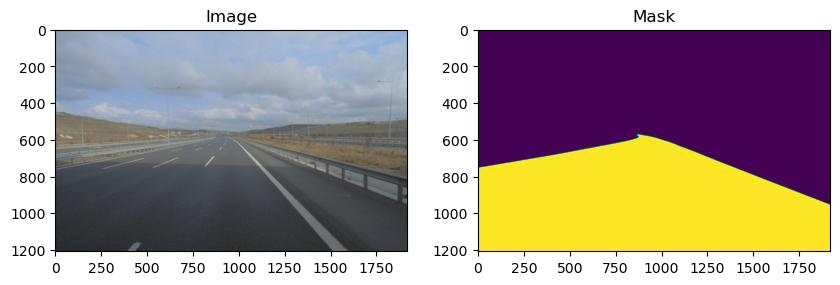

In [20]:
visualize_example_fs_mask_pair(image_paths,mask_paths)

In [21]:
def visualize_example_line_mask_pair(image_paths,line_mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(line_mask_paths[random_idx])
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    

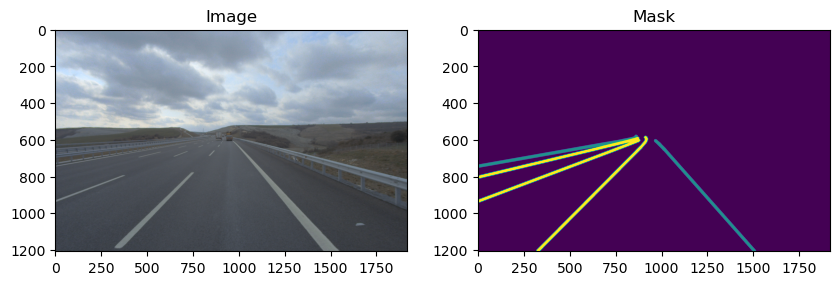

In [22]:
visualize_example_line_mask_pair(image_paths,line_mask_paths)

In [23]:
def visualize_example_mask_on_image_pair(image_paths,mask_paths):
    random_idx=random.randint(0,10)
    image=plt.imread(image_paths[random_idx])
    mask_on_image=plt.imread(mask_paths[random_idx])
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask_on_image)
    axs[1].set_title('Mask On Image')
    

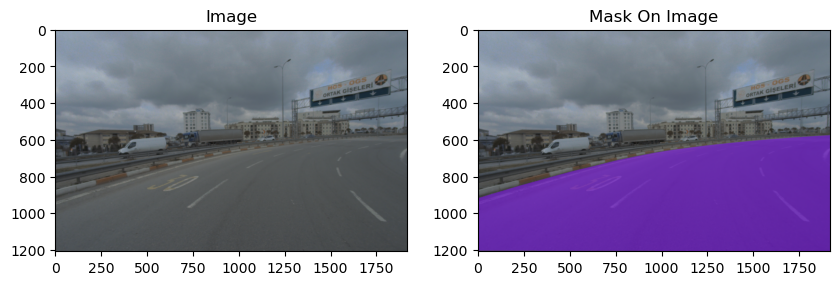

In [24]:
visualize_example_mask_on_image_pair(image_paths,mask_on_image_path)

In [25]:
image=plt.imread(image_paths[4])
mask=plt.imread(mask_paths[4])

In [26]:
print(f"Shape of the mask: {mask.shape}")
print(f"Shape of the images: {image.shape}")

Shape of the mask: (1208, 1920)
Shape of the images: (1208, 1920, 3)


In [27]:
for i,unique_val in enumerate(np.unique(mask)):
    print(i,unique_val)

0 0.0
1 0.003921569


In [28]:
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

# Preprocessing 

### torchlike_data() method

In [29]:
image=plt.imread(image_paths[0])

In [30]:
image_before_torchlike=image
print(f"Image shapes before torchlike_data() method {image_before_torchlike.shape}")

Image shapes before torchlike_data() method (1208, 1920, 3)


In [31]:
torch_like_data_example=preprocess.torchlike_data(image)

In [32]:
print(f"Image shapes before torchlike_data() method {torch_like_data_example.shape}")

Image shapes before torchlike_data() method (3, 1208, 1920)


We can see that at first our image has HeightxWidthxShape data format. Pytorch wants our images as ChannelxHeightxWidth format.

### onehot_encoder() method

One hot encoding is a method that provides us to convert categorical data into vectors. Fro now we have 2 categorical value wihich is pixel belong to freespace or not.

Returns a matrix containing as many channels as the number of unique values ​​in the input Matrix, where each channel represents a unique class.

In [33]:
example_mask=plt.imread(mask_paths[3])
one_hot_encoded=preprocess.one_hot_encoder(example_mask,n_class=2)

In [34]:
print(f"The dimensions of one hot encoded mask is {one_hot_encoded.shape}")

The dimensions of one hot encoded mask is (1208, 1920, 2)


## tensorize_image method

In [35]:
tensorized_images=preprocess.tensorize_image(image_paths,(constant.HEIGHT,constant.WIDTH))

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000234_75576fe22f704a23816456740bde3556.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000235_a1468fa636f9496aabbec371327890c3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000236_03a390ba28534f28a60a2d626f674103.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000244_bf75244a4b09401580da886b35c340d6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000246_c18d4001d69044e295e65591cf0cb574.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000249_38679c112bca4107ad224a6e7fc10c2e.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000317_83a1943ef1db44f78ca02aa5b781f37e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000318_c7c6dbdca6074ebdbf4862c9eef2967c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000319_8039409c190c4c41837e344eab2081bc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000320_d55283882dea435a8cdf45272b4a2033.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000321_0ca52168bbba40bfa2928cd1d3e553b1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000322_770b73f74db448b1888e8a7cbf8f25bc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000323_fff12c4b7cee4173a074df008904ae3b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000324_f3b7b08f3c3d4ed4aa0f6e5ebf2e417a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000325_9737e7850c3a4cc0a40696bcd91a9a47.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000401_ef6122e94bea4b86ae3f4e69a12c9a6f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000402_de86edf085ec45819d3183add2bf14ff.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000403_1ce295c6fdf24bd58f070f554af29d05.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000404_ac14b802d00447fe9756a8684cfa4233.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000405_eebebbd6394242339b10557d1bf44391.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000406_f2da98a999eb42c2a5ee5e2a494c13c9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000407_511ef67e4b6a4b86a29fd9f60af7c90f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000408_cad715fc33e8474faf918549d6f82b51.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000409_7e2d3413c7644f3d98f756f7c5f99eb7.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000482_4dd968a897144711bf25c74b11c65e96.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000483_0be1c50efeb24a6180a31e6398fd2a34.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000484_ed6442e8e31449a681ff01d663c5b0c2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000485_0c0615093cc944218b27032ebb999571.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000486_557cdb4f31b04c70ac5ee04bfb793428.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000487_40e76285ecd243349dffd7875e1e02c4.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000488_102dad074cae4b49801fd1b3890dda1f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000489_9c1c2ac528374dd7af383e6dc6ec04db.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000490_86b3ab20cb4b48aab74c32192b893562.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000561_952362378ed2439b9fff9091842c266a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000562_fccf5083c93a4c5b89f89420971495be.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000563_78d1baee949f41f5a0b52d7479682742.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000564_ab32d9a25351493db980989a28f48425.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000565_7a6d7c331aa3488eba76cba61cd4e193.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000566_c701a8ac6fc545e0893a75a09be66b28.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000567_00242aafb69d4fcf81d52b28bc96bce2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000568_ce2237ba988e49ceabed860ac40ee643.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000569_5489e5437fdb4ffba459fa569989c894.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000637_e26a71fe534f4b4e90b53165d9d32a55.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000638_42ef646a319a45f081a771884f52c476.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000639_a560258a625547a0953fd9befa378cf0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000640_67388004084e445a9805122aec3b0e69.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000641_725f5901d2fb40048e5c2fbaf718cc3c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000642_e7e491b9cce44932bbd6e560ba4bc99a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000643_6f426404fbd34846bc3539823b53d4aa.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000644_aaddadf2651b4c62a47b3f298996304d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000645_baf3ab29982947fcb50829d5803a1409.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000717_90be3c1f8bdc460296f703bc8d690760.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000718_b370c053eae44ce8a8b8c7a5b9393e3c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000719_82a26e4d545d4567b07447c1019afc30.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000720_b9201bba9e8b46ad877a6be56916cace.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000721_3b08becf561042698f44e128ee121a31.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000722_ce0acc19b5a749a5a9b6f5de7e9f5b0d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000723_f730430320924666bec1c3ac8472198a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000724_438dfccefc914806953dcba695cd1737.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000725_f01405d42fac4341862ca1618e171bcd.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000793_04ac22ed375c4c288fefc612c978eebe.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000794_4dc02ea5d285439d8a76dd53ac69c5bf.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000795_0f59c23cb82e41dd9315184bd2841ba0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000796_8d431fd64e4a4b379c7f457400551aed.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000797_7afc64ab2b1f4f3db320f2e9535e6a49.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000798_d61878c88d134cf2ac881fc5727248a3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000799_af48f037a36e4211b337317d5043c683.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000800_e5a28e02904b44578737a4479dba83dc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000801_0f7ebe94c8484ec0a090c4d5adc1b8d2.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000869_0535ca1abf96438ba31f790ebfe39d4b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000870_344851abcfc54fb59eb10ed35f0008f5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000871_52c555152cd74c37a53d882468a5911b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000872_ec4d1f5b0e86487cb75a94e38e575c0e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000873_4843ba88624b4a9a8805287af7372edf.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000874_7728f3254a0145359d78bf4d494335cc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000875_2e051b5d20d2491eb57b42a47e8dc844.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000876_7c95c995a23a4670b7dc7ecb78f1371d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000877_1c2da5763b7b43d8b8843bc424833499.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000945_39563cb174884c58b42947574a90d80e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000946_a933721eec7f46dab60378afe88ebedb.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000947_be026ac95f644811a000cf5ca04e8991.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000948_23d629c7949342eea72b4579f49632e3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000949_584e2757271e471992dd7d68c8310a41.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000950_4d750b2362fa4eb6a04db2a303bdc416.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000951_5965d655e7b943a392b15563bb54512a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000952_ff538ec284b140a3ba96941a43ed8213.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_000953_ce2ea99fd06d49ce9ecee91564329b90.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001021_9ad656acafdf4fbdbfc70fe11383a1e0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001022_17344007b52046a88a2e5178a2649b80.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001023_86d7215967474da79b96415923312ad0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001024_0d4c086dde3c4a9ab563844ba2461e2b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001025_43f3016c24614f509ef162fd98e92402.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001026_f72f061871ba4ab99065acf19231becd.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001027_684351aa987a4be58cc47a078a16e387.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001028_08e2ea65eeb942d6b7693bdc0616ba63.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001029_b2e99fdb484640929b0bf14dadfc23a1.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001101_ea104026d68142ba80b9566dfbcc3424.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001102_ec16e2e8341b4b08b88f54a93a66ec0a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001103_161d262019214590b4f39b0b24b980b7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001104_7ec4b823eeea4fa68578104626fe5023.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001105_2a9a6d1a863141a39db59b37b02063a2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001106_c349860dd0654dd0a7c17217ae89b1f2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001107_a0e262c29f4f4397988aa6f603901463.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001108_d3457e9768cb4383af8885322d6120d6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001109_631e07a83f944022a150d451eabcd25a.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001179_4574bab8fe144938bcc7664e9decc3a5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001180_d5f43d9950ed4f8caa7b302fddae2223.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001181_d607c6be55964b378cb7582f6b10bae4.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001182_f357f50dca744ec1b11b04a495316bbc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001183_c547fa9229fc465fb9781e1b878646e6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001184_863824630bb44aed9137a3149c0ff11c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001185_1e39224cffb04cd5a7ca11c02203406d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001186_07c0144ffe6b43ebaec77cc2aee8cd49.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001187_b898f3f9f091476e866081dd0671285b.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001255_8e35e3e4804148b58f5f49ad84f60a22.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001256_7ab7c0d33e4549c98b119951fed67f63.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001257_a05936bd2502473090e9f8918cef6130.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001258_f441679edf2b453cb274be90a6fbad6f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001259_89b27ab4f9f14ed48f985fb3f8ffbb55.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001260_359c23fbd1994b5aa8f7e172d218788c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001261_9547303a22b04f9aaf6777c7005f75c7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001262_c11859c594594c22bc4a64e565c6d6e9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001263_8550c0f9c72247ed9e4cc801ce0ee930.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001336_a98e74afe37e4aa8aeaa6c4df56044d8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001337_b1bf30cefc634b54941f21ccfaa1d4c0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001338_9e1f4132b7264e458aac1c60d81949dc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001339_9d4ae8159d24441a847b41c4ad07b80b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001340_ea2ad3b163c241faabc498fca29329a6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001341_af551102d2644e0b8226de8e565948ba.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001342_2824040a975340989df0df866f6ba5af.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001343_c00a44f4952d4a568fed9fd09eda0d1f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001344_e3a725d93a9b449884a1b3f23b742807.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001413_2d820d0f818448d9b160aff918aa4a1c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001414_05f147a306c8454a80cc37fa3ca86f5c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001415_fa9d193265384486b6e95ca2418fba23.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001416_81136c910fe540dd94164520f6e284da.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001417_e53f8e48d92243e38b914614e189c3e8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001418_ff22e2915b6148b5b765d65416154ce4.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001419_f5ee6d15a7254730a9b62ab4abecd209.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001420_8cc1a75690d54ed885ba7d1ff116335a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001421_38b87dda71b049ab8746dfa1bde36381.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001494_54f15e88e2f34476b7b783f241af4d24.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001495_0044877c615a436f9a62634b9c443183.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001496_d68f6017fbe64018b69c4078e7d128b5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001497_82df1eff5c074287ba8f86f6d1b6c426.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001498_e39f678e4d984fbda57d65e81f92be91.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001499_b11dfbefe84f43c184836c88dce37712.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001500_ec99ecdf16f04daabadac15869238480.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001501_516c97e28bc84946a9dc30f10462bfdd.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001502_5968a172a39f4f7c9de26ccdbef5989b.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001575_8f9e9d37c82744f2bed8b9c1f43c0755.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001576_4edf7ad1857441d9877d8a7bfb41f9bf.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001577_3c8da96813c14af4a6792d01f11115cf.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001578_70851230ad834390b80d66f3fd848e09.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001579_e77878e124a4458fb2e68b1105629729.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001580_d9be7fe9da524f6b960e1414db2f413c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001581_f7225530ab164be6825cc957f65cb91b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001582_2f1680515780484484a8459176376dad.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001583_eaa53dbe0914437da884f4f3827a5750.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001654_922ae330c4654da887e81de6dd0d74f7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001655_34b0ef84e85048eb8ab43236d17c12ca.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001656_7774f342bc774c2694182e59c23341b7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001657_909bda95a5c343658fc1221507a1d6b3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001658_0c2344976aa1486f9538fe49dca42de2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001659_3d31be3ed1ed4454a34519be6ae8cdd9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001660_2ec43861784d4c7bb9f68d0b2b54dbb8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001661_68cf12b799ba40ee8bc0d4878947a8fe.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001662_fcd667c62f664709a0037d733621fa66.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001732_fce54bb502d544e38e0666610c2fb695.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001733_e0074968b9e1463797d0dc1d7f3e2c89.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001734_fe54626bc8da4977bc3f90a54f41a54e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001735_bc6cdba9119d4417a1630fd44eb0539d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001736_72a4becc6b5a4c7b94fa8e27f639fd63.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001737_4327183f4d8541ee819d6eca310237f8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001738_5d64de47c1bc46acb25d377a0b02ba5c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001739_05d5fd269b034c4f9d1bba16075417a2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001740_86b42de89c6d402e9b9faccd79047d1d.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001823_ec3e998ed9604be1931fb0447c1ec03d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001824_dcd7be11a934447681a8f2870a19f576.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001825_4a605d77b7ba4a4eade08b8eaaeb4d66.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001826_c1e06d7c832248c78559cf05d08372ab.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001827_14c4c45c14604c02918e364225d3ce37.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001828_c1e627094ce24a5197b2741884f59673.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001829_0c223ccc41264f81a548dadf2ca34e8b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001830_3fc26c0c7eee4112aeb288effe1065bc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001831_00e913b8e29044a28cf5fda9a27149e5.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001902_a6d3a0ce6379449ab49e4ec7750608d4.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001903_46e6d413f3894812b8084b531e414786.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001904_166c0e511f2d43ea88d85e38a1232734.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001905_3017a669bbc1473cb4c6833326ce2835.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001906_9cd20a074a604224a3a2502c4f5764ae.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001907_ff38aba5d7584d6ba264e6b2df5bfa04.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001908_ae35be5f87aa4fd6b4a1b1aadb22f683.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001909_c969f5d2330748fbadb84cc888262284.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001910_ddf0935b73a54c959d58539f739bbe63.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001994_eb7fa0d62e4b49ffacb64073c254ab57.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001995_d507436afc504a71935c6d3de620ff43.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001996_7892daac56da40619bac30429384dac9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001997_0f33e893cc5b4289b88143b5e6bc51d3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001998_d0e649e674fc4342a9b815e4d12c630a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_001999_8ac87cf9bbb24ae9b29941219180b486.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002000_0a9ae2ba33884531a7f158cc9a9da995.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002001_ef4a2d4df4cf4713872defa2cef6bfb5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002002_86a91cdd0ac5446bb55308b82769a130.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002072_90d29d04cb7c4fec8764b16106b2049f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002073_31c10ec613964db8aaa0e64dc3cb2325.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002074_e6a5e9628a5c481f816d893be7ab4c28.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002075_f51aa25c6e314d3486bf23b04b26eebc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002076_9d2fe55543fb41dfa9d7ce30ddd16098.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002077_c78fdf897ec24306926c11f5b60d675c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002078_cb857fa016104e92be073ae7bdcc6062.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002079_11503d5385fe43419d51d306aa2d8c01.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002080_72d6fe87e09240f9bcee3d888721585c.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002150_608b4719c5994aa08150b810160c3a78.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002151_d80f7c8f6817418babf9b06775a7276a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002152_570f90ab78034b4ea369b800a68c5c56.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002153_550008e1c5aa411aa3a034e79df5f3aa.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002154_b8818b6de9034edba1944ce43064cd4a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002155_ac7f8585845d4151add93c18de240110.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002156_b37786a2054a432083398a29ceaf0df0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002157_7aeb2b7e27c140ff845fd8e7c344e13e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002158_81285f35bc46461f937edc9af83c6f13.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002227_4a706469c287496db40b07fe47e059e9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002228_6aac40d6d9c0409d92b1f2217414f62e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002229_a16878e49a8a4b4b806027acea936c99.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002230_fbe5a6ce10a74c01bd78651538d331e3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002231_d8c9aad44f744c329d1434f4653da0db.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002232_91ce6c3aa080435097881b32bf2f89e3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002233_eeab68928883482cbf755143d634cca9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002234_72434d348bdd403196681d68ccd7fe10.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002235_a913b6336e6642879f38b463fe8e01f0.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002303_42ac8616d51f40a8bcf897751ccf2e27.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002304_d8f4f61dcf8a4c70b957191edff1f2d8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002305_89b8a75549044c19b5159aac677a523f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002306_086832559b1a4ec4bd1d71013bd66342.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002307_a979b8cc1abf42b8b44c76e04514dc8d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002308_6d08c362a54b4af98c05fa7d1efdd9e0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002309_006c5f6cfafa4af9b4d4b137e344691e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002310_4779cc3d9115435eb22d65d31d04f5d1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002311_ea23dfbd07e64a71b03750011c55c17c.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002382_76dd1175add944088449023d18104975.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002383_d5c7a3678c574ee8a7099cb23b70634d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002384_f76a3a63e26241009298ab33f667ecb9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002385_5544e2e28915421cba2e4cbaef77ea66.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002386_8f90fba933a84f899ab8a6984d19eacf.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002387_b8be74d0db9d4d7a8cce4e550dfcd172.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002388_faca46ffc573402889cf0907d4748b53.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002389_952de7804a534da0b7eeb555e603a1c7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002390_799719b767dd49cbb2b033d9b0635ed2.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002458_a99a4e39d4874bc4851ecc6509675a5f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002459_6ca9a3486f5741dcbe696cf1558d8a26.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002460_9855e8eeb28e4c10b5d6bb7de439ea2f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002461_b3aa5bec2c8d4367a7db0467e6c0341a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002462_70769da7670e43a297a9a39cfd0cf025.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002463_0dafe5a427be4a2895cfc47bccda2f08.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002464_4787a5d5192e4981b2bfc03b8887d4bc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002465_469ceff499b748d09b244b01e0cc5c0c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002466_9d50d57766cd448cbfd6d142f7a64131.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002544_337ff9fcb4a044bb87b41d6c04aff308.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002545_2f87b062e44d4f87ad567cb1b8698b95.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002546_a0f90f37c621426ea141e29a7d34b68a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002547_4958233bdac345e1840fcb39a249d0be.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002548_b4444d7370d1491db27a19664c25d531.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002549_1dcd8f87fdb14bf7b4ebd172df10038b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002550_77d6962f0aa244bcba5f0e59fa347b38.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002551_2b9ee74939f2416f807eb0a00f9c72f9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002552_524dedea9db146e4aa70216602274a78.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002629_fdae2cc6120747999572955a572b871d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002630_05c9cee8dae54998828c4d85e3adf3c5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002631_bac56054350848328277e0db5e46c62a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002632_422a600f08a840d7a8df66166f88b35e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002633_144ac38753274052a41b706a7efe57a3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002634_a44e862191fc42d4abaca7fd3d8ae165.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002635_e3e52545864c44579e02c5ccc485b3d8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002636_89bd344dbf394c1f9d7a2d61b918956a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002637_8171f25abd804a65afb53dcfee01c5e8.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002706_0d51498e6ed64557a1c6c1d2328fa7d2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002707_84b27ad3404d497fb3e3f2927da96a5b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002708_dde7d4cd69fc40ce8284b8bff7a778e7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002709_4c967064f43543c39d6a5a91203674d8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002710_08528590dd70419ab1b65ee86d7e8a73.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002711_d88eada94b834dd0bee9d92ecd49c65c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002712_b1db80b5a9ee46d180e9ca25790f6b28.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002713_0deaf9ac707748cf9f1d649f34545d6e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002714_20afd0ffb4b5473d8ba20720385659b9.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002783_5998f022aa184d65a8456afdced4f335.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002784_d898f71312de47fbbf2e2fa2da400117.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002785_2aab2897b51f459bbbb1601e3f5becdd.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002786_fb97415e8fa74915afa8c022a8cea3fd.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002787_e881829c3efc4db3bde611e40e154fd6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002788_49e55699c09a4c09b76d0d1506438278.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002789_70b652ce0ffb42078c9ca6adea9b5ca0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002790_c67f3da7a9ae43f2abfd5af1304f8db9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002791_8373d7970a0a4ddea2263059c5aac26a.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002861_72e5de9e3ee34b4a94884ce209302566.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002862_3f34f1349d73463ebfcbfcfcff8cde40.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002863_57cc873c90b04a549fcec8e404fdb077.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002864_8deeeffe721c4a29b20e346879c74a3e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002865_f48d4d69e61b432db6304bf5db470502.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002866_0ddbbc68e3bd448b894c73112d9ecf43.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002867_50a2aab69d4c453a88065499b8eb3999.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002868_c6c30381e3db48628481d83445b1a666.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002869_728be8ffe99848138b2a7f0904095f9c.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002937_9fc67c3ef8134095b23860c8c8f4b258.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002938_0ae3d8d32a9a4723bf13544950977f86.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002939_04d20bd4d56940b9aab07478fe8981ac.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002940_6a0ea39f119b422b88699285f70a553d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002941_f9c1a432793646d68f9b2af0bc340f87.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002942_f0b91cd375df44baa1fc4dbedc4df8f6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002943_901a090a188f417eaa14e5792f8f436f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002944_e8302b4ca0f1461997a034bbf80b80ac.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002945_892d8d91a49c4b418be40c60dc377b16.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003015_e2daf2d18a324d76af625f034ab08253.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003016_fe88209c250344e6b06c5fa4325bccf9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003017_e6ad9c3ef3c64adc80f1fb3aed5c3e2b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003018_2129166f53f443d4aa216bbeba1e6496.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003019_5c56154108604b18ac50a8e5afd1a78c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003020_b8597818a2774081ab05d3683c78d74a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003021_1638207e3a714685b2b7612447d6a254.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003022_dd9ec901f25e40e4bf7fb3d12b2cea96.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003023_50e7505c0b5b4f26872a23ad6d8d1de9.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003096_233596eae1d8496f8501b5b29b7377d4.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003104_562b76388304414eae5501fe9ce94435.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003105_c73c4aa303ff41faa12039ba099e5a05.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003106_c76f4a5fcacb4c02bbd1d0b9bba6eda5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003107_e055da35a01c4be88bfce9fbdb7119c5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003108_07b99855c49b4a95ac5f9a1c167d64da.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003109_5b4b9bc06ba745beaeda84e75ddfc62d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003110_a7774e9e69e44c1d84b0c7920ee066a5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003111_30eace45497541bb8eb9197881e8db05.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003183_50ffa307389b49d29f63d435964b266b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003184_092ae51e03c5405bbb307ea41287bd45.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003186_95451ab46f3c4705a51310bdca3864e0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003187_76fe32f086ec4f68b9d57345b1c9a6f2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003188_0f86f0b773e546e48d0f684a6614310b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003189_2a54c7dafd924bd79ba349712ced7bf1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003190_513cc6448e014b318dd46bf77c2b8845.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003191_9757e7f081604c67a09a796b1010a7c8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003192_85da12d5bc7f47ab942369633de63b96.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003260_da716196faf342d6ad5b70662654233f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003261_f27cf15e49de4b8ab4125015e5c0d360.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003262_de3e770ea2414480834b9893fbe0af46.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003263_0ff86e7175c042fd83a1c9dc09f1bd72.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003264_df346d54914d4ad2bb254d8bea83790b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003265_6aa4d2e34a3a497ea9cfdd2c80d9e7f2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003266_3f91497cb9814801af2b8a05530dcea2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003267_83c75ae10cf44118941781a28199ad50.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003268_2f72c34347f648a98c45451935844ffc.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003350_b2bff99a3e534f7ca65a826e63ad57be.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003351_0e354b354e914cd991c74c49be2040ac.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003352_3e6d93ac0e3648df84b1d59d42d22029.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003353_de9a155b707646e69a5736ec83e25a5f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003354_831975aa79894f94ac879c5c976ffad2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003355_505f57ffd728491599069053436c6b7a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003356_db6476217ec74d55b639e1eca89d8ccb.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003357_1cca4ae3de1e41679bf4040efd0f45c5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003358_da0a0f95a53d4fe297c5f9eec5028255.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003429_d7387eb48d984985af65694b019db335.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003430_707c7127cb444f7594f46b553f32dbff.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003431_da736399c7c8454184ab62357a493e2f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003432_99bc49b5a0dc46e4bd508153e490c308.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003433_1b6062ccf56b480ba41d8bba4d529124.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003434_1a842385e54d4c88b689926273834e72.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003435_82c2f03d523b4717861c443bf98fa652.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003436_65ed9ee1d87b46d8a0e2818a3217d090.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003437_9a1ee1b2807a4f9cb6c8e0d4dceae666.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003506_d4fe922a7d294be6aacac222a312d6b0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003507_bc67add99bee4601af12a4e5a3128eb2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003508_be0578c5326642839c7329a5e783609b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003509_ce3ffb77b3ee4584b5e6f83389f0cdad.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003510_8d027f5e29314f2e8fe32b4a5cfaee4c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003511_d78b1efb244447f4a1f4e8b0bf345f1b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003512_3efdad813732490294a8cee0e956cb51.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003513_2f0a39e07bf44ea782bae3fad85888c8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003514_a644514aa2074db3a4a0ffadd633963e.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003586_761104002a324dad8b03422f62ed171d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003587_f9245b12d51243d5ab22b49f4b2b2cfb.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003588_69c2a9a29c114146bb36c0642d90926b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003589_d02ca1e2583944aabfe20c7db4962df4.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003590_d3eee28a1d7c4871bd6227c03734c028.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003591_06ce8dd3a2bd498eb526571275441dd5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003592_d0f9f9e3496d4da19ad9b1073c10cb71.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003593_301a1652569e490b868ed5edbc065ceb.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003594_6ce17912a6684856a5cc88770799d192.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003664_c1da0a00ba314448ae927ec18d6681a1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003665_fe4ef97b30a949328a481cd23c5847e2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003666_f6032bc6bc8142889684da50df9f7dfa.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003667_d6ce3217e64943839307746f906683d0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003668_f890897df4f2445c9c58cf32b09aab68.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003669_6d27c3b00d9140c2925ca1409ed8523a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003670_4ac6d551f5d3416a8954bf35d11bded7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003671_ac48d82fc07a4924b484dc71b47aea92.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003672_a858dabc421e4242890df31b5fad2023.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003742_abab7a5f191e4a95bbfa1e28b1140cd2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003743_90357020298341cabf1abc935dde1e5f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003744_d0ca1301326343688480a3081d28e26e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003745_f851706feeba4a8181342540dcfa9c65.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003746_03c12891573e46ab898930720d81540a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003747_8656ed1ab861483796db0c035cf5579d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003748_f6e6ab191c384002a93d59bdcc25a32c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003749_a855fa243f13499cb07b873e3cfaf160.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003750_c382aaa154cd4bbcaafc9904daec383f.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003822_847f688bacd34603bb97f4649f4d5bae.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003823_6ff255bbc38a40b5b5f53028cab8c660.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003824_e222f7e7c8434a5da5a0564c03cc6aac.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003825_5d1d50cb7dc049b08e0c5dd83d03df3a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003826_6a33d3e5439a4c36b9dd277209c045b5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003827_140729397fe447aeadaa049592e305ef.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003828_be3de0d6b918480aaaec14b5f84510fd.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003829_13c57b3ff1084577aef088c3face25ca.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003830_2ae3dc8e38fe4b95aa739a2a8ce176cf.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003899_4985ff6e93a041c28ff66b7b7261b759.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003900_da19fad2d71c40f8a3bb5a15937da4b3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003901_22e4525fa13442e48340aaf4365b7f0f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003902_ccdc84a03cc747cf89831e11b88d68f5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003903_973a958749a745f2b3f68de9508f0cdd.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003904_5f7ad4fde007412dbc79eda072213742.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003905_f51b78f2172741cf8cd33186bc9b8690.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003906_046e7af1874a4727b359468064f0507b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003907_6b0820f4f8c745a496f6ea7cac244f29.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003975_0895b9b26eb3443080f0c047978453f0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003976_ed646b8969694d0b8a12557ffc9b5aac.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003977_0ab18106b2b54adea7c8cf50a840d4cb.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003978_de39f4e046454897bf284c0360b9b06b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003979_3be92e1380f74349ad0a4e28e1146284.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003980_f78b833d02ed47dbba6863ce6982a326.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003981_ea8191beac024a0793cc8db7714fc685.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003982_8fb5bbe2fa694d9886beac582ef6fef7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003983_7083147e12c947ac94594aeefce71fe1.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004051_fc314a3896764fd6a940b444d3370338.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004052_4ca18de4e1c6498cb3b720f26606c8d0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004053_b15517180548499e818229873f04aa9f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004054_7fc0d7a4ff9541228aa4cdfe8df016d3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004055_4aafcf8041fb4b759c0c6dfad4946c91.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004056_9111f78265d545c88bd1dbbd05bfb6b5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004057_dbf9af781a3c4735bb288d2756e1be22.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004058_963f3321a7564e6ba6db5b7366a26a7f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004059_8c2501bf483a405b94f9a9a067509698.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004127_b6cf2038715b4dc8b13e285fb375f5d1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004128_ed5e1a6e4d3a48958ffa25de558a4bc6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004129_e8fcaab77ead4c44b7bda40f71a05ce2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004130_39665d4be9b44791a038f8a1f4b4e40b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004131_346b9165243346c9bb72258c51d055dc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004132_39a1b1d04ecf4862b3080dfad3ca023d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004133_fd236f112bbb4ca9a0639d5885a059ee.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004134_02a0d5b3196f415b91c7ab3222c844c2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004135_cc0b8cd2e6d540ca9d98bf46cbde4dcb.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004203_00435844818e498a94503cb9393988bf.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004204_740e55a16c2149dca5246bfaeed944bc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004205_a4823b17830648de8323f00af31a8d73.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004206_bdb67a6d46b54b0c9c270d05a3ad332a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004207_5b3eadce1f754d6fa9db84ee5b630778.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004208_c81a9959a94742d6a68d0072e29a9390.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004209_8c2ae08495c04560ba687c5a15272188.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004210_a3cb1e180962482699a8a4b50adbe192.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004211_c86e742b61ff42e78ea2cad78f66539c.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004280_6ae27f09cda441b29efe2b52a3d1f3c5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004281_760a678cb48e4028a7cc24026bc2cb37.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004282_57e874b80ae747abb8dd48cbfced9d86.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004283_5357d6504e9e4443ae5039717fcf507f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004284_955181028db14b69990a13b70897961f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004285_45e770e577f648ad93ded6463f6845fb.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004286_8e09674fc0874755ac1cbc42b4b6fc6e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004287_5642cefb95194f688b59a318487fdea7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004288_eca2743074b34caebedc223c5161bdc6.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004356_b4b1bf2c2a104956944cb07deeebda83.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004357_bc2629e636274315be9fe6c8c36bdf55.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004358_a44b99be1a164a5597c9c7e0ff84ab31.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004359_8424fc9c722f4434a2a95417cb05020e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004360_b9a6c2f23c8f4c60989e24241e5d9dce.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004361_1fabd6ee50094c85b92eb0722120186a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004362_76aa325b3dbe4b899a6ff4945a944e36.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004363_6b7b127112ae4e08aaa2981169082cfe.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004364_3fa8f7fa94a24531b7131a174f8d4e3e.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004435_f84db1ee06a941d7b07a1117ff099a2f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004436_436d2bd98ae54aaab8b6401f84d3e21d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004437_f5046a67e5c64dfa9b0c57a9961f6529.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004438_4590ce47c4244e17807b95c22e521329.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004439_7a57277f5ac24b0c94b52444b0a0b65a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004440_58886ea5f209421496320d4cc56b8d47.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004441_0c23523738d24e2791c7d06eac796711.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004442_b4a8457eb73746fba38263d221591218.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004443_4ba462c4154b440aa72098cb66777489.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004514_4efb681a1cb849989505dbce8bfa4641.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004515_391dbdf39233460cb67608822e21a301.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004516_b8331fa0012d4f9cabea66656b287a8e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004517_f8f622c1016a4bdb8478f0c7f3e356a7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004518_a7c2ee930bf842dda81df4912fa97f74.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004519_d04b00a5916949b9b67009653ae5f6c3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004520_6378c3362f554c98b28f1b9a39a4413c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004521_2174731e92be4f47b002cf247ebda819.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004522_cebb9affa1dd4afe8d15c738a86517da.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004594_970d8446a3ea46a6a6545343d73106ac.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004595_21037f4e9ce14159aed05a73c00104c0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004596_3e5989f60be64423a614b5644de24ac2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004597_48c5144060cd421fa2862d72e35014e0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004598_80c304524b7e47529f8a40baf97fe2ea.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004599_2aed5f36b0ec494b9bc23d1ba7ee9486.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004600_8c49acab3114446ea5adc0ff37c568a2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004601_8783fdaaf68e45d895b94d8c614809c1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004602_b4f4e67aa59a4c71b8692e5f30ea827c.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004673_433b628104824128a2db3c403c31f9aa.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004674_f6747862aef94f009e19b3d00a68736b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004675_7849e875dec8403dad739e66d7629403.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004676_0f31e93950854e6086e3220a6dbef610.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004677_56a46fc6666647f782f668f4c4488dfc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004678_80ab79159fa34ba0be5a00d30201c482.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004679_aa5c2d674325495aa2fe96916fb0707c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004680_73b1d2e5f33c4c898045672fc660e72e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004681_b58fa76c46734c609df3ad0356256efa.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004767_1fc3e97c93ae41998691241686994df6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004768_a76802c43ea54b62be46cd45c4d62e72.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004769_1de9f34fdf744b168c5f7f00bec5219f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004770_9f31e16d5b194e38bd26d8fe63ea720d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004771_f1726d8a80b045049b522745d130c3fa.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004772_1d3e6fe0f68c497e8504a2e84a56effc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004773_7935900d707b4a52b67b014a16ee44c1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004774_f28fb0f2f3574905bb30397f7201e4f9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004775_c6e56d3faee24fec8c2b46d32cf316b0.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004847_2a34f56a24444bc981efa9795776dded.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004848_bce6b6932c2944838b4ccfed17a69e12.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004849_7494573726a94c6183dd6a6f778df986.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004850_919b3b888b34458ba3c5467e66115a8b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004851_9e22afbd7dba4cb18937d5898d3afe2d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004852_36000b3c37804cb2869bf7d329f604ba.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004853_268edf9fc73a4ee48b4ecc4876c67d7c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004854_e99b90b0bc7b4cf78abd64f92e0c752a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004855_c23d0252b02a42d087071abcba33679a.png
C:\Users\Beytullah\

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004926_a9b6a289b5024c1e88c43cd2b7a328a1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004927_c969849d3ff54b178516e6f8531e985b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004928_4070a0b3e22a4243bdf012237c83b5f6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004929_a820465378974e31828c559e5d407ccf.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004930_68d65a4e32a347d09b7670dd257256d4.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004931_f7a2eb9d2d904a8796237a55cf486238.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004932_4e3a9a49a9ec449fa159e24cf92e529a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004933_bc38c60719894e4bbe33b622bfb65704.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_004934_a073fc3214054d9d9dedbcfc7f3728da.png
C:\Users\Beytullah\

In [36]:
tensorized_images[0].shape

torch.Size([3, 224, 224])

In [37]:
tensorized_images[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## tensorize_mask.() method

In [38]:
mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\mask

In [39]:
tensorized_masks=preprocess.tensorize_mask(mask_paths,(constant.HEIGHT,constant.WIDTH),n_class=2)

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000234_75576fe22f704a23816456740bde3556.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000235_a1468fa636f9496aabbec371327890c3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000236_03a390ba28534f28a60a2d626f674103.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000244_bf75244a4b09401580da886b35c340d6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000246_c18d4001d69044e295e65591cf0cb574.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000314_cb33fa80940442ddb871e030ca641cb6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000315_7e334a7531764844909ca13e6b3514a9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000316_85c4a901030a41bdaee23a913e5def5f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000317_83a1943ef1db44f78ca02aa5b781f37e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000318_c7c6dbdca6074ebdbf4862c9eef2967c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000319_8039409c190c4c41837e344eab2081bc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000320_d55283882dea435a8cdf45272b4a2033.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000321_0ca52168bbba40bfa2928cd1d3e553b1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000394_b5dd187a0df74371bc8f986ce4e561b4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000395_008c85535da54f16a1f61e02c13760bd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000396_2dda4a7222ed4403b506e916828a580e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000397_416c4331bd50406993a9550eed18f788.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000398_fe7e86a82dfd4528ae299736719ae3f7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000399_4ebe43294a6647c2b9a7b97653756e64.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000400_90d1691b9225456da8d8265cc7421183.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000401_ef6122e94bea4b86ae3f4e69a12c9a6f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000466_8532bb0e25fb4f96847cf6d33d36fbae.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000467_e4681a2731f94ebb98a45af23dea6309.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000468_57eefb6df6824b5ab4621a32c6022c14.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000469_71158a3899dc414a8be6e1a6337aa544.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000470_9033662e2de34af4a82b9df3fac62416.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000471_52bdea6fd43f4fb7bd597f5372f77e36.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000472_042a408234d4435b8d9e80e72e48794c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000473_93c6850f410042aa8320f3a653c70972.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000559_bd33b913f2e84770861a857e82e7cb7d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000560_f230898fdfa34d3d840c1044fad28351.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000561_952362378ed2439b9fff9091842c266a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000562_fccf5083c93a4c5b89f89420971495be.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000563_78d1baee949f41f5a0b52d7479682742.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000564_ab32d9a25351493db980989a28f48425.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000565_7a6d7c331aa3488eba76cba61cd4e193.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000566_c701a8ac6fc545e0893a75a09be66b28.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000637_e26a71fe534f4b4e90b53165d9d32a55.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000638_42ef646a319a45f081a771884f52c476.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000639_a560258a625547a0953fd9befa378cf0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000640_67388004084e445a9805122aec3b0e69.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000641_725f5901d2fb40048e5c2fbaf718cc3c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000642_e7e491b9cce44932bbd6e560ba4bc99a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000643_6f426404fbd34846bc3539823b53d4aa.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000644_aaddadf2651b4c62a47b3f298996304d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000710_491a71223c7e4f2497e098f26916cff1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000711_2ae7708eb5a447449cbf8070a51ca80a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000712_6848b4a5eab74023b61249da54507aa5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000713_333d89db98b44b9fbd25f31f018f1291.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000714_83b06ae3d4704e4e93c2115acb092987.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000715_029f19136f5e4172a1ba400be4e63b37.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000716_bbe2b281a2f1485cbca47a9b84cf7f40.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000717_90be3c1f8bdc460296f703bc8d690760.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000785_a03d54a104a64779a7214cbc9b572cc9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000786_d331d3d2369e46ee9b960dfaf8217e72.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000787_1586198064d64b649537489749619054.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000788_d1193a2c75e2449a8fbbd1522d9ac68e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000789_1f52f931d14d44088a4a484e2f0dccce.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000790_7e3c8d20af5f49f7bb875a2f91c1c1d5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000791_8ae39afa5b754b20b7e28857e8551909.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000792_1c9b9f8393ea43fd9c09f78f03ec4aa0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000862_d8ca2d3d6cd24f5ca86d04995885f6de.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000863_591a1a202264468ba1d0ee843bd9ac5d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000864_e899c6c777fe4e2c848a0b7023af949c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000865_57bd737d9bac4548bf037efa7a7e397d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000866_da370c3d30304a9b8772b452e6430bbb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000867_d974d3f043fa4ca0961399b541cb5ab3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000868_9684ac68384c41d3a774c90f97072230.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000869_0535ca1abf96438ba31f790ebfe39d4b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000959_c0c0282d5f1a45799f68c61b68e3ce3c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000960_f80d58a20e9045a7b4fe984ad5570af4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000961_60f611f835d541f78445c69036951a4b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000962_ae4bcac8ea6b4334871dd5bed3830f52.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000963_f8d2ac5b39cd4e6b81dca5f14d444688.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000964_564c93768eac4c6db21d83bcbbd2e829.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000965_87f09ad6124a4be4884771867c21061c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000966_92018f4b610f48b5b44d1c582fa8dc54.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001036_f9f4340ee49c4109a3ed8236500f4238.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001037_a775935e125d47e0b96f004a8613c9da.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001038_43112f7607514e7e8723f90e37ac8b80.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001039_4414b12b23ee43b6a88cb9ed7edee9a1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001040_134360c1969240ed84314b82001f45b6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001041_ad7cca274d1b40a2a1ea6ce7a0eb5107.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001042_aae0f17775384d63a0b65bb96aeae386.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001043_9cd0dcba905340229bec62e0cd1fed6c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001111_ebdc22b33930446ba246d77c365ce482.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001112_ce1e8b5861d84799bf699ab5b08f0490.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001113_d7d09914a0b14e0f8e72958470c5757f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001114_3409b8c616224c71a1d7a01a78bf6208.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001115_b4cf8eb371c240a890280b71d171f224.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001116_e65091835bfa4a90a084c79dbd7fb7a2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001117_94d7eadf2fbf4bbcad7c7e3e02371959.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001118_24bdd3172bfd44b6b3ae64fb9cdfb3c5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001185_1e39224cffb04cd5a7ca11c02203406d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001186_07c0144ffe6b43ebaec77cc2aee8cd49.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001187_b898f3f9f091476e866081dd0671285b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001188_8d11b7cfc8cb422981c411218a19b658.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001189_2096451193ce45488e71cd5112e14f9c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001190_322d65de386d487a94243a96f35dc357.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001191_570c72e12d424a15a88d25c8f4d95412.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001192_eba07d23cabd42e6a1099a43ce89a5b2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001260_359c23fbd1994b5aa8f7e172d218788c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001261_9547303a22b04f9aaf6777c7005f75c7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001262_c11859c594594c22bc4a64e565c6d6e9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001263_8550c0f9c72247ed9e4cc801ce0ee930.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001264_cb94a4bacdfc40729de1af2f57d13e42.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001265_a998cbd10af54358874214c8e5c9e094.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001266_eedb2c227fc74e11b4d30694b28fc090.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001267_e306965bee8e4742a7f6a9190d95d6ef.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001334_3340623763f74769a850831019ff9360.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001335_3a831e46f2e84b4aa97b3af9a09e49d3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001336_a98e74afe37e4aa8aeaa6c4df56044d8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001337_b1bf30cefc634b54941f21ccfaa1d4c0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001338_9e1f4132b7264e458aac1c60d81949dc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001339_9d4ae8159d24441a847b41c4ad07b80b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001340_ea2ad3b163c241faabc498fca29329a6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001341_af551102d2644e0b8226de8e565948ba.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001407_5c89608ddd37406eb4a1d8eb6b5d0ba7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001408_e549ed68603a44239aca2131fc872227.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001409_4ae339a6eecc4c4ea888ece086a1ca4f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001410_ad81911ea7754b29b9e69551c3570405.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001411_340118bc452d42da9def3f265cf2e0b0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001412_4a60fc16a38c4a45bbc0a61752a14772.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001413_2d820d0f818448d9b160aff918aa4a1c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001414_05f147a306c8454a80cc37fa3ca86f5c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001502_5968a172a39f4f7c9de26ccdbef5989b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001503_675bea7a7e5a490099cbb192e91ae292.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001504_105ac748881640cfa08efca2a1802a05.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001505_91452346b32d481eace1b7fcaffce7d8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001506_eb94483bc1ac47f48eb4de8d5e823b1e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001507_b16c0d063b2d45d5a47d54e4fdaf566e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001508_844ed053bed344d8a4240959130f5c63.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001509_1fcd4b16d4d24ae2b3025b1456701926.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001575_8f9e9d37c82744f2bed8b9c1f43c0755.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001576_4edf7ad1857441d9877d8a7bfb41f9bf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001577_3c8da96813c14af4a6792d01f11115cf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001578_70851230ad834390b80d66f3fd848e09.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001579_e77878e124a4458fb2e68b1105629729.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001580_d9be7fe9da524f6b960e1414db2f413c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001581_f7225530ab164be6825cc957f65cb91b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001582_2f1680515780484484a8459176376dad.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001648_96f40b31d7c74859b6ffd68723a301fc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001649_29ab643ea8234c30936a808dcd602503.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001650_88a68a7feac64ab9ab6f78ee4d8ef423.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001651_a9ea89da60304f09a65b76f682cfdc9e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001652_cdacd72067c647718c7504887d514ac4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001653_71fde44d44c24ca89bc7bc72bdf68d23.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001654_922ae330c4654da887e81de6dd0d74f7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001655_34b0ef84e85048eb8ab43236d17c12ca.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001722_5688e35188b7494499069fa93facb59b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001723_b544a62880d643578f01a77b21b2555a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001724_e40aa96fe5964cf2b10f99732c29c035.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001725_63c6dc14f97c497d8c2b3e218d625293.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001726_8e03f318ab214f4f90a1bd08783f12b6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001727_12ac690a058d4fc5ad1028fe455aa8b0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001728_132f0e81e9c74ab7aa0674bb9f9fae3b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001729_3e87e5e4d8d84e8d82a8adbbf08b330c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001807_98f78a8604a54a208be314bdb7cc7489.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001808_d79fa09f862143fbb231dc5d086077b5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001809_39c62fc4933a460f8b5ef1d7a0e7807b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001810_275b834407de4039994e46f75d2b8b27.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001811_b02531d8fe034645b9ce2bad5b2bca75.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001812_b97fccc92b674096af80f96c41725a18.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001813_ec673956d82648ad9862a1e6f2c97313.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001814_a6a9abf9e6514d7eb9ea4eb3cb4763f8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001878_0ee9f406811241bb9aa24f1490dcfd4a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001879_67ff5d701e7a4e78b50f694984aa6cd7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001880_f455dc39095944bcad5884afc227bae9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001881_d26f0bcac2d34eaf974696d6053e20cf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001882_f33396c0b0bb4f218c1ff89a06e402ec.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001883_883e553576f34ccda986733362341b9b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001884_04d754f37b58448ba0acee26ed895e2f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001885_6c541548c5ce4e88b8f1c8498bb0d646.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001951_0bbf656a1b924ce3876834b92e26f091.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001952_f6f40aff5977469e97f835585d96a736.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001953_0e43fa69035040f2ae87832ccee3c94f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001954_823cb715220941cf9414f988bd34cfdf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001955_05dbd6dc4881475fb3e27e3d54d2ed44.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001956_da7789d73cd640c785f3084d9eae508f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001957_7124d81301974923869d453ab203d582.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001958_0c20534cf57244ec8be1aa3f37c566a5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002035_358a44dcfde847e3b1945a516a229483.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002036_573537891b3d40c5a3be0263af168282.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002037_7132f08dc9214994bae2363a91352acb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002038_9fefeaa2ccde4284b0f4c215ed625ffb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002039_583e486f552c4276b74c8589c9fa1ad8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002040_a5eb3a7fbf394b43ac9a96e508052e9a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002041_cc0617aa7ec94f62b18ef289ce5b29a5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002042_f35d8cf44d824e0da909b847e6f09e2a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002109_0b6eeea78e0d4b0e97cb1e6e0bf49eba.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002110_3e3395e4b9384e5e9b9a596dc3ee382b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002111_c89bd727a4624e6985f4ccfc8c7f7a68.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002112_d101c68b38c342be80255e54622cc453.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002113_3630cf18404c4940bdba52e3c8b4462c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002114_62cf9c2e7ffa4445a6c709544b4bb25b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002115_b4aa733ea6854888b0ea900e5fb7aea9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002116_3c791bdcf6dd483f888b3502c90985e6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002184_931e8d713da749b0bf94c6b59e78f7a9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002185_f00d1671bb314863a41392bdbebcb888.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002186_bff1def11d0d4ea6a677c30e1580bd31.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002187_a7cad4ef7d6043e5bfba762c3a302bbd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002188_e9c3df2e084e4915af70ec29ceddf04f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002189_89ceb5efc3be41c8acc2d674df9b7e79.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002190_2b2b3f29d7c044a1914d32d3dc15f218.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002191_424bf7f0c00a4e5e8e2d7190f639b292.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002262_776240a127a34561a6d91710e35fe5a5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002263_645ee4887bd0474da2d37fc4361b01bc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002264_aa1cd5dab18c4e71b2c6445c5c858c58.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002265_67fb52b757394cf3b4b608f4d7954d42.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002266_ffac4a28a2c5496fad4b3145ea6c6763.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002267_787f735b58c54de1b07e3b99369b0ade.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002268_75d69d198d3849918d2a736d7050d823.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002269_2157d27ed90648eeafcfe7c0b28feca9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002337_da16a6d90cd74bdaa7335928f02abb32.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002338_2c8b6a7f23c1468b9c90784958ce4688.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002339_de9c94fc37c648cbb5f23f9661b4117e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002340_0b8d92ec9cd94822aa1bffa2b452572b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002341_7ee14372da2f4894adf46337b4f5ea8e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002342_3a014d396d2d4389af365d96b6e8db4c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002343_96f57ab26393436a96d37beb79943554.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002344_b2e5078e6dde4506969f878d1418b211.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002411_106c83865b81447282faa24d79919280.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002412_913fec462e1e4df5974beff174712a83.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002413_848630ac25c54ea5a6a50aacb2c99f22.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002414_33cc2b441f914a52920dc18192d1b092.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002415_942925b994b54d278549e909ff63d13c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002416_924086fecb2f4c7b8207455bf806c48d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002417_c6e3783e7a904bd3b06f6641627eed0f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002418_34d5e27576154072a38bce2ba0d9e9eb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002486_d743819c7a7948f09058ca0f6feace6a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002487_d277e3a6c5f8449a8a86dd7aa48ab42a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002488_63eed687f3da45acb9ad7e84cd766f19.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002499_f6482b5be94a44bdbc14d3e43102aac1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002500_e209d00f6f924edc8670c6b2b5e6ead1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002501_69349725b119464cb27ada73b4582dd6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002502_7ab2210eddd048fc92b6f9477941b01e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002503_7b409866a7334b8b8e783802f8335b0f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002569_b0895770feac45a688b8837eadfc9d10.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002570_cf02d3cc365d439f8d47c17ce8083a48.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002571_d7fe62540f0a465885ec54e02e24beec.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002572_19c0d8f3ae4446e6a18053e12b350fcd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002573_f8b8f6a163db4daeb83983d5249b5c58.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002574_5a6f3aeaff65432b8d324f82e73664ae.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002575_bfd6451ac60946a79178661b80573bea.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002576_d228f4864f1e4004846f26e3db28f6b9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002653_eec726f280ec4db68ed6b0ee4be28ba9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002654_e6cdbab6c3094e9aa7e044fce2f137c8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002655_9eb8c1e16b9145deafe7417438c31485.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002656_ba5a550260db40b3ae25e319ae2970c0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002657_f350e0d6a5f74b8db7dbf47e50860ba4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002658_398bd8437bbd4d3b834c1b02ee149685.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002659_21884ac8c6c2408090e39c0ac27120d2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002660_5f1ebc84d38849f5a3a0f642992d6900.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002728_b62656b549124a34bf85f89c2107f7e5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002729_6416f7d8b071443896254388b699b9d8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002730_28a6018a9ca249ea9b8562e2b361acd9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002731_aa8a5e8fc54a41dfa223a87298f51cf4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002732_e25f411333c64adaa5b953e9f901dafa.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002733_da8532248792480ab6f35b62655d43b5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002734_04ff67dc780749aebbe17e71d472dc8c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002735_4d8700ba2f5c4646ba31d2bd1155aaab.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002802_6cad71855d384d1bb56e9610d9f21d30.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002803_f4a5025803ab4584968581a65ce5c3b7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002804_da678e9ea5ca4777923cdc7fa6dd864f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002805_dae2288bcde4403d8689cf55b272d07e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002806_be38c1f52bde43039bbfe5449271e250.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002807_8d3cb036e45e4b2cba3b982080ef5693.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002808_5e9da5fd49b64097b8d764dbf75fa281.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002809_519b81d6ffc84bf589b016ea52d70a9e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002878_3c83a7e7e8bd48648d64a2ad6dfbf877.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002879_6f31182e9de846d7960a4a0d3315a1bb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002880_958365c55a3f496bbe58fd6a6033fd9f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002881_5e6887041bb247af9d23a281dc13b87e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002882_f24a0eadef7a4baeb1d4d32040a22f0f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002883_99b73c74afa34f73a4db52769b89d92e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002884_9895d3ad958a429190201044ece97075.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002885_9ddab538e169495eb2fe033918fb1121.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002955_9b8d96e9a4a54de6a4c9238634d66c36.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002956_23f39549bd844c9abe20bc4a4eb6d14d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002957_fb684dd786934ebe98eb3836c77b8157.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002958_2b3493c89cd04dd5b501c9808ec78a3b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002959_a6d304a04c4f40b9a5893c04d4c54df8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002960_b8d23af0e44e446685202ec3f9811e6c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002961_f04a2cdc8cd24123bac0d06ad5e7c82e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002962_14b9fa91fc60469183e3337262e68fea.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003028_5807b11a1447471aa26a992a0f014ad7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003029_bfbbd1e7e3064d43a2e2a1713d7363fe.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003030_d2edac5d90294ba1a94475f6c0ca155f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003031_bdfd3d831d84449ba7862834d4e9ecbe.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003032_cb6de27373cb48769523171b716bc486.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003033_fe6de72ef3674a088f641265e7689474.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003034_e76c709de9534a77a60243233be489b7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003035_596d83d5f2964a6abbb3d98722f30f4e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003131_8801cdd8cc3e4a1394704ee04f87a75d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003132_ce3bcd0dbcea40368ae57fadf99dd513.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003133_f09bf6ca7f004d2ba1a083f1fb8e439a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003134_9b32696e5baf400c92bf556b3e3d4190.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003135_8810fa1a2d2f41bab2b8a9d68f3fce36.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003136_6a8ad0b223b848c4bba1c070cf7d1872.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003137_9aef32d5da674093a81de0528c6f1c36.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003138_dbbb420c9aa54cfdaa46ac34baf98db4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003208_9ee34f9cc3cd4e9b9793d0e4f03789af.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003209_59f7c0f30648408b94fb3a2c0cf49e82.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003210_2fc0be4981504b6ea29413946a511005.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003211_b6a8d90e27af4466b42022690ce9bd9d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003212_c252edc525fa4699a1f468a25446f1fd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003213_92fea424f5694f5497382d03bbe0d7d2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003214_fa4a96c2ad624dfba0a8c3d0ebba168f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003215_913e0a24093a4b65baa6b3c691ccf70f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003284_10289b366e4f4601a069a3289619c783.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003285_11c32520284343629f4dd90272a72185.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003286_e32076cc0b4d47ada4eae4cfa3a72ee9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003287_f8d115e94f7d458cbc3f25bbc317488e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003289_51f0cfea0ef54e1c928e095351c6caec.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003290_7aaf0d94b70b45a68bdbcb3ace072b1c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003291_c1e998b93d2c4574b4090b3a2c4dc3d3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003292_e21529b6db4148859b970d192a512cc7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003369_f25a3b3d3ed44be793fac702aa4c5e18.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003370_d69e2eecf93b4b2ca8eace2cf0bed580.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003371_1f9ea43794f54a3a8f31e5a56eef6843.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003372_e6704b80e1454c6ba4f55d58e2e60020.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003373_0266d057d38a4acab713f4d8fa66b8fe.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003374_02b4d4d57b2c4769bbdd29a8135645ec.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003375_05105e88014342b1aa3a90a70b72bebe.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003376_1c37f7f556ca425386f7a252f1d46699.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003442_5404af6458664087bf3c525d0cc307a0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003443_0ae142eb553f4402a9d80016907894b9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003444_76911f0abfcf465c8a5621529d5c08ec.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003445_a88f4164caea41d28c043bb686731402.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003446_14943b6c4ae442668e42e3c91df049de.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003447_41862c2cd0b541b8bf05762e624eca05.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003448_6caa099ab9ec457aaca114ad702d724f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003449_03f22fb993f042a194f70e736bd7e426.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003516_18e49be36f9140dbaf1926c5bfb1048e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003517_3d340e687d0542d28b4033e3177cc3e8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003519_dccc7e61846e408784f5066e986afcda.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003520_4ca687a7d3874d3a9ba65ac4bf2f5d46.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003521_4dcbaa1c809748cbb9d54b80ac831730.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003522_94fea6a46de141ba8a76c1255a00a20b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003523_d018c52bf7ad4cdb8fc13e839d40ed19.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003524_a6ead383a0fe422790ca8dd2188301ac.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003592_d0f9f9e3496d4da19ad9b1073c10cb71.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003593_301a1652569e490b868ed5edbc065ceb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003594_6ce17912a6684856a5cc88770799d192.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003595_c671a461393a46f195438875df27a63a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003596_cca26c953b7640dfa694bd701bf10b8a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003597_f0a1f56ea8034ea0a83e2a90b628f7a4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003598_43cf2608367c4c2982996beac9483f9d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003599_3cdbcf56bcfd46d995fd3cb828fdea13.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003666_f6032bc6bc8142889684da50df9f7dfa.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003667_d6ce3217e64943839307746f906683d0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003668_f890897df4f2445c9c58cf32b09aab68.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003669_6d27c3b00d9140c2925ca1409ed8523a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003670_4ac6d551f5d3416a8954bf35d11bded7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003671_ac48d82fc07a4924b484dc71b47aea92.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003672_a858dabc421e4242890df31b5fad2023.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003673_f37b06bb4e064284bf9596b2093e1df8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003737_cdb39a5796b8484b93bbcc095de6834b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003738_3eba35567ddf4dbf8e1de87b435a307e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003739_41ae1cd0707f4c38833e748cbffc9665.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003740_34b761f4f9894a44b3de86a198cbbd0c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003741_c9c2fd97dece4733bda1776958320540.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003742_abab7a5f191e4a95bbfa1e28b1140cd2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003743_90357020298341cabf1abc935dde1e5f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003744_d0ca1301326343688480a3081d28e26e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003810_9627de0f458549f694549a805d403734.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003811_a75133dc2c764ab3afeed102d64b316e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003812_bda9dd85d9494bdb9e01c7e9fc557646.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003813_941ef402035a4b079a6f0acef92846f9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003814_f37c79067085490ab69d51280ac566d9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003815_8f0c8705c8cc4559baaaf99776a28075.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003816_c297fb55af254a6fb7dc9811f5be7197.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003817_9b687c270a6d44229c40714f059983bb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003881_a0b9eea7eafe422bb09e89185ac64a87.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003882_b01854ef931a43218476f4bae1fa3754.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003883_b02916552d8e4b14a6d104e25af11408.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003884_a7229f3a1fc04033823e4532c8bc18a0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003885_94e378582bef4cdc8dd18350c7d16eaf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003886_365494ba932848b69d328ac6487b7b5f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003887_acc20495a2a8479c8eb258ccbd585b6b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003888_415a15f7468a408fbbe97befeaf9cf2c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003955_407faef2bb8448118856a2542f09f2df.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003956_9d06a6674b6948d8b124294ff6450c3d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003957_f26f0a2955294286a263a8a5c1661a10.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003958_b3609323d8b64ce89b2175c272872e1a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003959_061ebb5222d24052a31209dfab6ada82.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003960_be2ea664fd8c472cb307eb71e865908f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003961_2dae58053b924b1a9dd1173198d6a051.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003962_318e9ecf5b124d4bbec46814ef2dd771.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004028_85ee18eb259846948a376533a7fa17f1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004029_df447c039f2d4d8fb70e4f50175806df.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004030_84ae3583c93b4fa9823599dbb7524941.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004031_97b5279eb8a74d5187567dfc49985465.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004032_f178eea5b41d4ea381d87796854bcad8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004033_89a38ff6717146c290e990f2cb9adc20.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004034_960fda66a5c44c22b00536d22325167a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004035_bc7afbc3fcd94750807af663fbaa66fc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004102_b3b05a357c2c4de69b48d5b2f78507fc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004103_152f5c2f3cbb4de39333e4d05e8b39c6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004104_bb1d60d174b74c97803dfd4927030559.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004105_a4e01de400ab45439e5004f42d9f8392.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004106_3ab47b5c99b946c9b4eee9840f3f5d17.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004107_05e54f299cd04d9298dcf27b287ca5dc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004108_c9cbf35ad1b240f9adeec58c0174add5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004109_c1f8b8e89df44d669f86e02ad28fe9a1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004175_6f21a856a2ba4b5aa6be1c43e6ac0c64.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004176_f00f0f6a282e43e69cc5e4cbc2d1ad2e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004177_35c70b26c77b4739b777375923acfcb0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004178_7a045b8bf2364061be508a1606c26aee.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004179_ba53011a41aa4c319f50bcf44b928656.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004180_56e5d12fcd7447d8875d5a1204dfdf7a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004181_a3c05f11fb96435f89ce98f762517ea4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004182_8e7298d01b2d4d2c824c7112ed0386d1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004267_9f745fa96c094a33b3eab7c7cc5b8c6f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004268_6a724ff74db24d27be6c6c710aaf7d82.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004269_46fb4bba190c4d1487285cb777193a11.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004270_7ff4c2dc6d0941539fd6e953ea98f17a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004271_22e4242f74934ae4ad96b8cbe154050d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004272_18973d3757704232ae31740e5905a050.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004273_1c9d8755d86c40cfaa6b2a05f9667d15.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004274_e010e50373054f28b23769dde40a689b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004340_c6386ff02e5442d2ba714adfdf6f456a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004341_0333d1af603e4b6280369139c5d5e20c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004342_b228732284a842da973576b929390d5a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004343_8bbcf30613b84b82bf1058241ccfc097.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004344_3fa7c24dbf9e4ca1ad5f68a1c49e8b78.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004345_f213c2b4337b4167b9632a5c28917a48.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004346_12e42718e27a43bdab2ded879cbba4d5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004347_d58522a693204ba8ba450af86618301f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004414_694da050291d40b3bc101314bb84c4b7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004415_d883fbe2cc71466c9b63163d42c895b1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004416_3c4a28e9bba34aa09da56347367a0954.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004417_cf2c1d4448af4f44b1fd3d3408ad2f5b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004418_b5294d4d4043455787687ee16abdbeac.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004419_5721c9d3f80a4404b03df8f28a8f599d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004420_4ea7ab0f235b4f1db3d52ddcc3241a49.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004421_0380f1b5cf18413aa8775ed63fa87b65.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004491_18202a5f2a9c4d6199af5b1b0895ddc4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004492_3555047369ea4aeabaa84605686408b5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004493_2c4da079777b47eeaa5faaafdb1c5c8c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004494_4fcedf7bd06446039152390a003e47ab.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004495_ad7ce350e06345d3a8c6db7c5348c8bc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004496_b5c20a800b6e4198b14cee46e5350598.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004497_31068b9775534370837ca2e9d4c4acf4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004498_ce7ca01a3c8f40a3a28a69e7a2ee898b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004567_83c392ebac2f4909a313d2ab5568fce8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004568_2e1f4c8b87324201a0a5ff29bba03d78.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004569_e1ea445c9cff4afca227fe6b161c9fff.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004570_44722f2689534d258a8deeadff198631.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004571_1025324c4303471880748c77db7adf0d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004572_11540c547f71495a91bb4e6d84619949.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004573_0cb5a7611c614b9d8d70aac2f28e3708.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004574_f8b3ae962bef4317b34d708bc7fa9c8c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004640_a0335b964607460b8c22e9eabe620014.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004641_cb62860f6c6d4f019c5ace1c9f1b2b8f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004642_2e8e319c172048b7a1128149cb0ab3a6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004643_77b81f4b51364c40899f34376d89f10e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004644_20ceb05c28be441ba807b55485b9f80e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004645_3d7e1f443b244d73aea8f3adac42df1d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004646_f713207a5ee341bba0c9d099c1205994.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004647_2353c2a4d8a34d2ab243149dfb8769e3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004726_a3977d3bcbf1474ca2ed41366c0fdb97.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004727_996df778a3ca41fc824731b5729eb29d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004728_ef68ac3f0e9b4106991a29c634ba8ff7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004729_b5668d11dce94134a616fbe4497b0b85.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004730_96fc1ce9570b4302a841520ddca3bb79.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004731_4c02ecfd89164c9ab3942d8f18ef64d0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004732_41a9cb02de20497da54e0a1d3ee2e07f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004733_907af16eb68d4dfda129b506b24e79f3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004801_2f207d3e54764c82bd97c018bf7fa580.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004802_151a1825d9694872b1e1dac046abcf7f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004803_bdba4633b062460e86d39a4bacf465a7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004804_0b80c0e0bf3441ee8cdce6496613d02b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004805_8693015591044be596dc7f81ce4310ef.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004806_25da49702a2f4e2c9e9cb03715b33562.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004807_718f5da29f8f48d1a582cdb37da374ab.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004808_faadc2fa1dc24b518647e3d394ae1499.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004873_5bab66adf5794b07bd86c0d0070dcfa6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004874_7800f70fbf04417ebe4b3f9a635a4c9a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004875_e444cb91458c4e81b10186bfb1bcb9c0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004876_ce4b079249cb4a89932464ce67716193.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004877_d5f5236f671945b4b8447db353c28d2f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004878_4ada378ad92844979e0fd4c3d56d46bd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004879_d23410d378884440956e63ac2f73772d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004880_2c30b01a89f542a089311f3d4a5fbfb1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004947_955b21ac27324169990d128e49d84626.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004948_3c7321e74f454392bbf850421288cf27.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004949_c4f7dd27e17a46fea79b07a9a6f732da.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004950_c10d8bfc2d0d49a780f3e1a5365d51ed.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004951_29a08376f3c7425789f04936d1bdc4b9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004952_ced98c1240bf4581b07926e7957c8fbc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004953_e10782ba123a42528e6c048efea43f0d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004954_2657594183364bfca9d874d9e475589a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

In [42]:
tensorized_masks.shape

torch.Size([4660, 2, 224, 224])

In [43]:
tensorized_masks[3]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## Model

In [46]:
model=Unet(in_channels=3,out_channels=2)

In [48]:
outputs=model.forward(tensorized_images)

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 59857960960 bytes.

In [49]:
outputs[0].shape

NameError: name 'outputs' is not defined

In [50]:
tensorized_images.shape

torch.Size([4660, 3, 224, 224])

In [51]:
outputs[5]

NameError: name 'outputs' is not defined

In [52]:
outputs[5].shape

NameError: name 'outputs' is not defined

## Model Training

In [54]:
# PREPARE IMAGE AND MASK LISTS
image_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out", '*'))
image_path_list.sort()

mask_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks", '*'))
mask_path_list.sort()


In [55]:
# DATA CHECK
preprocess.image_mask_check(image_path_list, mask_path_list)

True

## Train, Valid and Test Data Split

In [56]:
indices = np.random.permutation(len(image_path_list))

# DEFINE TEST AND VALID INDICES
test_ind  = int(len(indices) * TEST_SIZE)
valid_ind = int(test_ind + len(indices) * VALID_SIZE)

# SLICE TEST DATASET FROM THE WHOLE DATASET
test_input_path_list = image_path_list[:test_ind]
test_label_path_list = mask_path_list[:test_ind]

# SLICE VALID DATASET FROM THE WHOLE DATASET
valid_input_path_list = image_path_list[test_ind:valid_ind]
valid_label_path_list = mask_path_list[test_ind:valid_ind]

# SLICE TRAIN DATASET FROM THE WHOLE DATASET
train_input_path_list = image_path_list[valid_ind:]
train_label_path_list = mask_path_list[valid_ind:]

# DEFINE STEPS PER EPOCH
steps_per_epoch = len(train_input_path_list)//BATCH_SIZE
print(len(train_input_path_list))

2796


In [57]:
print(len(train_input_path_list)//BATCH_SIZE)

699


## Train Freespace Unet Segmentation Model

In [58]:
model=Unet(in_channels=3,out_channels=2)

In [59]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [60]:
outputs

NameError: name 'outputs' is not defined

In [61]:
len(valid_input_path_list)

1398

In [62]:
if CUDA:
    model = model.cuda()


# TRAINING THE NEURAL NETWORK
for epoch in range(EPOCHS):
    running_loss = 0
    for ind in range(steps_per_epoch):
        batch_input_path_list = train_input_path_list[BATCH_SIZE*ind:BATCH_SIZE*(ind+1)]
        batch_label_path_list = train_label_path_list[BATCH_SIZE*ind:BATCH_SIZE*(ind+1)]
        batch_input = preprocess.tensorize_image(batch_input_path_list, INPUT_SHAPE,CUDA)
        batch_label = preprocess.tensorize_mask(batch_label_path_list, INPUT_SHAPE, N_CLASSES, CUDA)
        optimizer.zero_grad()

        outputs = model.forward(batch_input)
       
        loss = criterion(outputs, batch_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
     
        if ind == steps_per_epoch-1:
            print('training loss on epoch {}: {}'.format(epoch, running_loss))
            """
            val_loss = 0
            for (valid_input_path, valid_label_path) in zip(valid_input_path_list, valid_label_path_list):
                batch_input = preprocess.tensorize_image(valid_input_path, INPUT_SHAPE, CUDA)
                batch_label = preprocess.tensorize_mask(valid_label_path, INPUT_SHAPE, N_CLASSES, CUDA)
                outputs = model.forward(batch_input)
                loss = criterion(outputs, batch_label)
                val_loss += loss
                break

            print('validation loss on epoch {}: {}'.format(epoch, val_loss))
            """
        

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002139_4cc36052a7f04833ab0af6361368684d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002140_cca2e72f96ce4b48bd9f608065b7be5c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002141_49f5c16721df48a3bcc239a5f40f7a0c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002142_c22a8d4269074dcbb99dc2e1282b0d0e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002139_4cc36052a7f04833ab0af6361368684d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002140_cca2e72f96ce4b48bd9f608065b7be5c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002141_49f5c16721df48a3bcc239a5f40f7a0c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002142_c22a8d4269074dcbb99dc2e1282b0d0e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002143_a224d9a019284daf8feef585

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002179_abfcde6ca6dc4ddc9aa12d7c9fbe1b45.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002180_b9dc6d5f14414a90b99153761c9b0b6d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002181_5d3cfed9060b4c1a96a5844fbad1b4fa.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002182_845484abb99d4533ac94c49fdc7696a5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002179_abfcde6ca6dc4ddc9aa12d7c9fbe1b45.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002180_b9dc6d5f14414a90b99153761c9b0b6d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002181_5d3cfed9060b4c1a96a5844fbad1b4fa.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002182_845484abb99d4533ac94c49fdc7696a5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002183_b316236cdb2a4ccb9abf8b3f

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002217_b0f356c78b6a41488ce1696af5880236.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002218_237896ca9f5f4305a5f1a1dbf425c647.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002219_fb2cedf646e6472bb7b5526b572da468.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002220_a89a3f9007c7478c86fd62aedc1e1a14.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002221_52e5cabbfaf24b13bdb5ae0f18f61d04.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002222_3c7f85810e594ccc95f75eb97ac792bc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002219_fb2cedf646e6472bb7b5526b572da468.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002220_a89a3f9007c7478c86fd62aedc1e1a14.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002221_52e5cabbfaf24b13

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002255_590a4b1aece44c62b4681e6467d91f51.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002256_7f1ee76ff3134a038bc3e170ac61db97.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002257_c5075508c7fa493bb4337d2a6409949b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002258_481239968f1e4df1859a9cad8d6c2d7a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002255_590a4b1aece44c62b4681e6467d91f51.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002256_7f1ee76ff3134a038bc3e170ac61db97.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002257_c5075508c7fa493bb4337d2a6409949b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002258_481239968f1e4df1859a9cad8d6c2d7a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002259_915b840bd4234c05a81f26c0

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002294_e765ff4c09384f798922c6c5fa0dc97a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002291_8a400073dc944688b4c1b49637829703.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002292_4a2d062079f24958a7cdca0114d18aae.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002293_e35eaf9a76874a1db5f4f4f7fc877467.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002294_e765ff4c09384f798922c6c5fa0dc97a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002295_521c370a53c74c79bdd48cbc0c070e0b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002296_b57ad333d88a4119afa0c88222c96532.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002297_6b4e86d704404a7abab0c7d410ef8891.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002298_3cdac91146914454b2a5a042

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002327_0edb463a07ab4b0b966db4192598b310.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002328_4d88df87165547649f92aab9d7b0abfc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002329_6fb30ece60834cda8c8e2eb4963b291f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002330_580ed28d0ab04bee90439f8bcf4f1101.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002331_e600eb2a193e466ca418fee2fafd6297.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002332_0c80b1744ceb4b36934b26d8e33a818f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002333_2e170eb7f04c4478bb97cd949b4eb317.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002334_21a67e3ee8a341c78c1461719014e20c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002331_e600eb2a193e466c

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002364_f474ed1a9df442a1abbd9a9ac4b19c3c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002365_a3917a578e1a453f81a8ce85946efe56.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002366_2860e83e050d4d439bcbc1480e3414af.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002367_ec8b1a9ab5c84a50b826bc6efbffc221.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002368_b812645157d64cda935dd0c9ed8ca8db.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002369_509adc00f07445ce9bccb10250157774.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002370_01a1ca25b2194e4da167e576f5b7851a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002367_ec8b1a9ab5c84a50b826bc6efbffc221.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002368_b812645157d64cda

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002403_6e1d3c814ca54cb1af8ce59da631753c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002404_28e54cd1737c4bd5b871c9470067d04b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002405_a903d881a9bb4f5d9bc390e59b537535.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002406_c493619a94274e02ade3dd7efa0b9910.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002403_6e1d3c814ca54cb1af8ce59da631753c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002404_28e54cd1737c4bd5b871c9470067d04b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002405_a903d881a9bb4f5d9bc390e59b537535.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002406_c493619a94274e02ade3dd7efa0b9910.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002407_cf2635065e104109a82e6c9b

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002441_ca401327ddc44b259c7a7243c5dd9256.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002442_c1609365f0e94006b680d263b6c72569.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002443_bc28598fcdf24fbf818f63aaddf5de4a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002444_43bb4eb494a1419088c07a921277e812.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002445_4fca0e66732d4542ad173a52a5478d62.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002446_6bee77083e5547c2b35515dfd3bed7c9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002443_bc28598fcdf24fbf818f63aaddf5de4a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002444_43bb4eb494a1419088c07a921277e812.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002445_4fca0e66732d4542

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002479_c72955993dc444d0b09e9f7916f9508d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002480_dd44ecd98d52425e849ee092ff22ff28.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002481_6842f0250d1a41389ead998536c40ee9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002482_eada7e590ff54514bb19016c1cbe648f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002479_c72955993dc444d0b09e9f7916f9508d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002480_dd44ecd98d52425e849ee092ff22ff28.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002481_6842f0250d1a41389ead998536c40ee9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002482_eada7e590ff54514bb19016c1cbe648f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002483_dbab274b59b1459e8d7fb60c

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002525_fbe8066ae0d544b8b83190a5d7ec1330.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002526_cb89d31e9b4741868a591e6ea42581bf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002527_83040a84467b4a19994d63749f382c73.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002528_b820dd3887bf4981ad0b86c0a1566c28.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002529_8e3042ff40b64cc4addc54a9c2e1dc5e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002530_757f0db67f33474285d0e4fcddb96a14.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002531_8134420cebde40d58e74bdf3480cb078.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002532_76022e613a3c453d8cdc22632a41490c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002529_8e3042ff40b64cc4

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002565_73a18e21c1a94fc8900f3f339cd195f1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002566_3b16eda08bfc4bcebee6eb4116812492.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002567_94e200b04eda420c84a5144cb33680a4.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002568_6da236af0ec0430a836d9fd211260cfd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002565_73a18e21c1a94fc8900f3f339cd195f1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002566_3b16eda08bfc4bcebee6eb4116812492.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002567_94e200b04eda420c84a5144cb33680a4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002568_6da236af0ec0430a836d9fd211260cfd.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002569_b0895770feac45a688b8837e

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002609_01fed5f9f31648b582c9dc4644afeb55.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002610_023384009ed34eceb3dbdf20e0c9de36.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002611_40f173b997a248468519bbad95c31d90.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002612_5c1da1bddedb4234875fae2a469fe829.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002613_a34aa025212f4a32b76a56018533d214.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002614_2e5256f207454e7ba27b6e3e65668f60.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002615_42f48e0965924b1db82eacf27811e8c8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002612_5c1da1bddedb4234875fae2a469fe829.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002613_a34aa025212f4a32

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002648_10f8f4d9557e43b3b19f925290c62413.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002649_2557173516b84b1b935f04a00a44a64e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002650_cb02373c3a26498fb5e5cc04cd691271.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002651_56dfb10072654490a9fb7cf53a0c4a43.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002648_10f8f4d9557e43b3b19f925290c62413.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002649_2557173516b84b1b935f04a00a44a64e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002650_cb02373c3a26498fb5e5cc04cd691271.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002651_56dfb10072654490a9fb7cf53a0c4a43.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002652_27bce2d8f9c444eaa1420859

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002687_5c35c3b271e341c3b2ee4fe4a7f1b4ea.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002684_772e8f5fba3243de96da575fd5618637.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002685_0d178dbad45c4d65854301e43677e063.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002686_823d0d2b0beb484e9024ac1f5d9daa4b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002687_5c35c3b271e341c3b2ee4fe4a7f1b4ea.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002688_258ba755ff0441868695d11c34c27e3e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002689_d16bca6ba8f849ac966d095f31916ffa.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002690_8b9058cc1f6048338371b4592cd7f8c7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002691_000af947f3a44960838317a4

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002720_3f9ebd2bf1904dd2ab816c55e52f6274.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002721_46ce400a315f4efd81fb314726218dc3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002722_dd72d8b6f23f409a9bc8c2245673f5bf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002723_f82a696333a24aec97517f5f1f15c8ac.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002724_3325e255d1a4436e8b3f5a86e15681e9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002725_ce9730a8784c479a9f50fda8ea39031d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002726_5605b4fb5869471188ca59eb9edb06de.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002727_3c08411c65a348c79e3fc3053288c4b4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002724_3325e255d1a4436e

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002757_4c694dc1704d4312b7ddbb9692bf78e2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002758_df23cb3fbc8649a48e106d307cd6e126.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002759_f8b263284deb409997deb03707d4490c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002760_5fde2c1701024515ad9f0098be51be62.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002761_e3687d52ca0a4e15823315ce7e863457.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002762_6eba3b4e63de45108c046f42237fc50d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002763_d5a296cfff8247529877b114d2e7e834.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002760_5fde2c1701024515ad9f0098be51be62.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002761_e3687d52ca0a4e15

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002796_f9f968800d984b5086a0a815c66effa9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002797_f8e7fdf1a983461ca6a3337e09de8cdd.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002798_14b4836610ea4a19ad04ddcf1bb45996.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002799_5fb7aff777c14276a0798c92baaddef8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002796_f9f968800d984b5086a0a815c66effa9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002797_f8e7fdf1a983461ca6a3337e09de8cdd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002798_14b4836610ea4a19ad04ddcf1bb45996.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002799_5fb7aff777c14276a0798c92baaddef8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002800_f148902ebb7146c2b30d485c

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002832_88be83ccfe754ea190bb849a6a3d80f1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002833_7ece47010c10412da8e24e0f8f1efe7e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002834_f273c77f9a824a92bc0fd0769f70f7c2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002835_24f0d9de61a148acbdf9c53b03da27b7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002836_f6a7c7b210524a328cedd67154453efa.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002837_069b187bb7894074acc5cb10a54e70dc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002838_4069974583834fde89ab6831653e5c29.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002839_084be245edca4491aee6ff1f2e9dc68a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002836_f6a7c7b210524a32

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002872_9bba2e27e7814130be7454933b3f319e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002873_c9c2658f3d1449a59ad297a9636fe7a6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002874_52ddd1a317a640cb808787eeccfa6cc3.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002875_58ae1eafd6b64d2abdf23186146071cb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002872_9bba2e27e7814130be7454933b3f319e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002873_c9c2658f3d1449a59ad297a9636fe7a6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002874_52ddd1a317a640cb808787eeccfa6cc3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002875_58ae1eafd6b64d2abdf23186146071cb.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002876_6239a505a30f412592f7b5fd

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002910_bd32f6060252434b83b495ef1051f6aa.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002911_34a8f6a3f3a4441e8bb1ac4c3537eb5f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002912_3f23d1cc57384f759469c81d4c685508.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002913_1cae1f11dcc24daab6ec0b0ca0101932.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002914_7a95004b21dc4088bd9c4837d30111b1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002915_1a5bfd2012f94fafb753818cd2476218.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002912_3f23d1cc57384f759469c81d4c685508.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002913_1cae1f11dcc24daab6ec0b0ca0101932.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002914_7a95004b21dc4088

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002948_164fcaf9278b4cecbd05954e54b1c074.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002949_4eedc610f67541ca8e01d91eb352f047.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002950_28490b5e2c42428f8eac653f694de2be.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002951_c72b83dd11eb4cecbf32e2c5d57715ac.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002948_164fcaf9278b4cecbd05954e54b1c074.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002949_4eedc610f67541ca8e01d91eb352f047.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002950_28490b5e2c42428f8eac653f694de2be.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002951_c72b83dd11eb4cecbf32e2c5d57715ac.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002952_abe70e1fbe5e4c44a3c17c7d

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002984_dc8ae8ab0448437bbacad47c99ef84f7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002985_3b4806baf4ee4ccc9e63fe9407a4ab53.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002986_7b443bdbf2084c32967c418b841f1a0b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002987_a15a8e1349cf480287d534dac9214026.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002988_925d645324c946679dd23918e6f38f77.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002989_63777556d59445379b5495ba3f7b68d7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002990_4adeee9cccff4e1fa6e633603a47e14b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_002991_ed6ceaf0c9094714af620620e6bcf161.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002988_925d645324c94667

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003024_17adcb9da7304fddb5d9bd453b8a1d76.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003025_a76655b84e19472cbefe42366344fd26.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003026_1bc2f42fb7c541e691308d9dae23df2b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003027_1e9b4a0510714b54a95cd45904000d23.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003024_17adcb9da7304fddb5d9bd453b8a1d76.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003025_a76655b84e19472cbefe42366344fd26.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003026_1bc2f42fb7c541e691308d9dae23df2b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003027_1e9b4a0510714b54a95cd45904000d23.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003028_5807b11a1447471aa26a992a

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003060_d36f49d87f664ed596a5a5ebb6bf9f94.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003061_344a1d07ef564dffb2a4b8d5895ccaf4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003062_43b065d5a2f94eb295dbbe57620b24f2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003063_b92d3bd416284ddfb6a398990a7d3171.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003064_9b1bbf7843244aa1ab577acdabcb1e9f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003065_acde7a05d0874ea18a926183cb449813.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003066_f07e67ac635146459209f46c983e675b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003067_abb077d5ba4c4106ac57c382ad684cb1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003064_9b1bbf7843244aa1

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003109_5b4b9bc06ba745beaeda84e75ddfc62d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003110_a7774e9e69e44c1d84b0c7920ee066a5.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003111_30eace45497541bb8eb9197881e8db05.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003112_9453557f5a634fc990b129c5674849c8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003109_5b4b9bc06ba745beaeda84e75ddfc62d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003110_a7774e9e69e44c1d84b0c7920ee066a5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003111_30eace45497541bb8eb9197881e8db05.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003112_9453557f5a634fc990b129c5674849c8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003113_36f7284ee7994389b5c308ce

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003148_72e26c78e66041bcbaddc017c4408365.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003149_f51cc739fc27479faa6ccf5eb0514cc9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003150_5d720b2322c94306a2f51af756803644.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003151_6c7424ebbd084b85a84233d42431bf84.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003152_dfc7361e2a5743309c1d9557e217ab1b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003153_c21847712b51486e8e37789d06dcdd91.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003150_5d720b2322c94306a2f51af756803644.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003151_6c7424ebbd084b85a84233d42431bf84.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003152_dfc7361e2a574330

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003187_76fe32f086ec4f68b9d57345b1c9a6f2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003188_0f86f0b773e546e48d0f684a6614310b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003189_2a54c7dafd924bd79ba349712ced7bf1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003190_513cc6448e014b318dd46bf77c2b8845.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003187_76fe32f086ec4f68b9d57345b1c9a6f2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003188_0f86f0b773e546e48d0f684a6614310b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003189_2a54c7dafd924bd79ba349712ced7bf1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003190_513cc6448e014b318dd46bf77c2b8845.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003191_9757e7f081604c67a09a796b

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003224_2909074a5dc74f6f9816cfa49cd28854.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003225_e57493588669420ea41d92e3884429a1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003226_440fd1e56a194cdf86fe799cfef33cad.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003227_4b4a752742004299960566b56153badc.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003228_f4c1c1a1fc234d0d85bf16ae4f463d81.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003229_aa6476bf674843c8ae13de97177f94ba.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003230_35145185b5a7406c9d36df1dabba0b71.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003227_4b4a752742004299960566b56153badc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003228_f4c1c1a1fc234d0d

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003263_0ff86e7175c042fd83a1c9dc09f1bd72.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003264_df346d54914d4ad2bb254d8bea83790b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003265_6aa4d2e34a3a497ea9cfdd2c80d9e7f2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003266_3f91497cb9814801af2b8a05530dcea2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003263_0ff86e7175c042fd83a1c9dc09f1bd72.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003264_df346d54914d4ad2bb254d8bea83790b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003265_6aa4d2e34a3a497ea9cfdd2c80d9e7f2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003266_3f91497cb9814801af2b8a05530dcea2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003267_83c75ae10cf44118941781a2

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003310_afa7babb8d4348f394c42bd057fc0281.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003311_e631ea3ec4374381a3ef5debc3917dbc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003312_adbfc2ea984d4a979f61396674e70195.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003313_8bb67249a8714325b7c88936adf58b6d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003314_ace1057778004289925fa2e57cdd9408.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003315_f8ea72608afa491ba135c13d3d39805e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003316_59b1c8324dca45d5befe16ea116864bb.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003317_3b9610c15c60487c8d6268a3e1802dc8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003314_ace1057778004289

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003351_0e354b354e914cd991c74c49be2040ac.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003352_3e6d93ac0e3648df84b1d59d42d22029.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003353_de9a155b707646e69a5736ec83e25a5f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003354_831975aa79894f94ac879c5c976ffad2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003351_0e354b354e914cd991c74c49be2040ac.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003352_3e6d93ac0e3648df84b1d59d42d22029.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003353_de9a155b707646e69a5736ec83e25a5f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003354_831975aa79894f94ac879c5c976ffad2.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003355_505f57ffd728491599069053

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003387_7de54496a09c4367b846063936df4b62.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003388_eca282d566ff42c8bc2f81c6aa06cbcb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003389_88ccdc68ec114f2b832fd71e520b0921.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003390_9872d4293b944aa28ad8ffee99d130f6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003391_caad5a13b35446beacc4a25427efc6cb.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003392_826442185d5b43b9bc84f18c40902f5e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003393_dec6c1e630af415aa21cee76d2ef1ab9.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003394_fb73fe0b2df443c2b101153763e212d7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003391_caad5a13b35446be

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003427_c683e20ff8604f4980e6169bd4e5a688.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003428_f50a7bb408294aa7bbc7f074b423cd34.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003429_d7387eb48d984985af65694b019db335.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003430_707c7127cb444f7594f46b553f32dbff.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003427_c683e20ff8604f4980e6169bd4e5a688.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003428_f50a7bb408294aa7bbc7f074b423cd34.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003429_d7387eb48d984985af65694b019db335.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003430_707c7127cb444f7594f46b553f32dbff.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003431_da736399c7c8454184ab6235

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003466_607951d247c34a31a4addd3697ad0f63.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003463_96e67bcc2ef44fe5b7e82a76deb85451.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003464_6729ee23f2504dcdaab6a38366d2267e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003465_aa6c5c59152f48fc9b9b0d2455926e7b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003466_607951d247c34a31a4addd3697ad0f63.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003467_883590276c18499fa770e0cb6b71a662.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003468_9f9a0ec17546433d8960ca4a3b3dc184.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003469_b3bc8feff09c44ac8357abfaa9143bf8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003470_fbf6f8fde21942d8ae50aaf7

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003499_83a2558f026f43ed8b73fc35a9963818.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003500_edcd59487b114724a21563b9506d0208.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003501_044c6e7c85c94f5bb53a702bd08c660a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003502_980f977cfe464fd4a0b10034bba2630c.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003503_0a23d09010a64d29856fb9b31c8e8130.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003504_bfa9035e10bb4d349f1140041159b9da.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003505_1777960fb5334ef5949914cf6e89cef6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003506_d4fe922a7d294be6aacac222a312d6b0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003503_0a23d09010a64d29

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003540_fcec148b09fe4ad7aab475571b7a84f6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003541_5ac618dcaae2439598a2ef10f2bad63b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003542_e106dcba34674ec199f1e104b1847088.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003543_9a01cd6080a949db946cc16e0569f77d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003540_fcec148b09fe4ad7aab475571b7a84f6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003541_5ac618dcaae2439598a2ef10f2bad63b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003542_e106dcba34674ec199f1e104b1847088.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003543_9a01cd6080a949db946cc16e0569f77d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003544_250a947df80442859013dc83

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003576_1bfeff07f5194885ac15c1f49f0e775f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003577_b821244f0b8f4acc97300aeb77d9a216.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003578_d1ea428a2cca4de69f74ff8ef72afb9f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003579_c051d7671607463db6137e8c9793fa51.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003580_abed324d2ed24c788788c155d93c53cd.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003581_10edfc8b896d4e29a7a275517475df4f.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003582_a0d57893d273447fb6cc154e67be2813.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003583_68dc7b606a9b4148afd6b18b7aa70d9b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003580_abed324d2ed24c78

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003616_7608efff27fa410189816c5ebc1d55de.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003617_93e6c728d3274019b946421e5c845cc7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003618_c65a3ef0fd624aaeae9a515db1bc5d5b.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003619_adb8297e72074931b7da1d3a32c68ef7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003616_7608efff27fa410189816c5ebc1d55de.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003617_93e6c728d3274019b946421e5c845cc7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003618_c65a3ef0fd624aaeae9a515db1bc5d5b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003619_adb8297e72074931b7da1d3a32c68ef7.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003620_e736dbc55f354ae09430c436

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003655_f20e532d011243c2b672a811296fa48a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003652_e57f314a1fe64531b33f40defbf9a9c4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003653_b85a149f315b41d18c0b65cb1eb51752.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003654_0e80c7e8b5e8429c857fbc51037e0040.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003655_f20e532d011243c2b672a811296fa48a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003656_36dc69fe9b774aa09b58bb81cfe74d21.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003657_e1a430eb30a84353a2f8b9e7de9fb5d0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003658_42eaec764b9942d2b9db02700800cc1d.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003659_9422e5a687304120a4be2d23

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003689_cd9b4bd182ff4fdaa3217ccb459f5953.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003690_65e498e79ed945dc93f5a524cb1aa19d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003691_fe90ee03e5a14465a49d7d50f15f3128.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003692_f5a4980ea59c4bcb8e94a456e05e03a4.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003693_bb728e8f0aba41db949de49def9978aa.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003694_196258717f63439bba75f46bf8d447ff.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003695_521335522d844481b0f2397cfc257050.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003692_f5a4980ea59c4bcb8e94a456e05e03a4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003693_bb728e8f0aba41db

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003728_4adcb48344324ae496553500f56442b6.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003729_4880ed1c61354083a05b00cce616e473.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003730_418cd96f896e450791ddc46d9722eda0.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003731_be58b36038374213a46e4b836acc356e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003728_4adcb48344324ae496553500f56442b6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003729_4880ed1c61354083a05b00cce616e473.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003730_418cd96f896e450791ddc46d9722eda0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003731_be58b36038374213a46e4b836acc356e.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003732_4d167521492641688dcf7ce0

C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003767_a7bf570f53c64506a06caca3f8fda3e8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003764_92c62f20f6e2400b806ce84887b320b8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003765_9a72a9041c4a471d8a4485168a79210f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003766_1ecbc4f5164f4e5aa2e42231b1488861.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003767_a7bf570f53c64506a06caca3f8fda3e8.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003768_4a5c9df6ee654972a0eb2fd48d770a2a.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003769_7f590b9351ae4f1cbe2608019edaa832.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003770_b132982a666e4598829d75261ed1d5f1.png
C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\img_out\cfc_003771_941cea2bd03f47789013750a

KeyboardInterrupt: 

## Save Model

In [46]:
torch.save(model,"segmentation_model.pth")

# Inference from Trained Model

In [47]:
tensorized_test_images=preprocess.tensorize_image(test_input_path_list,INPUT_SHAPE)

In [48]:
test_outputs=model(tensorized_test_images)

In [49]:
pred_test=test_outputs[0]
pred_test=torch.sigmoid(pred_test)
print(pred_test.shape)
pred_test=pred_test[0].detach().numpy()
pred_test=pred_test>0.50
print(pred_test.shape)

torch.Size([2, 224, 224])
(224, 224)


In [50]:
pred_test

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ..., False,  True,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Text(0.5, 1.0, 'Prediction')

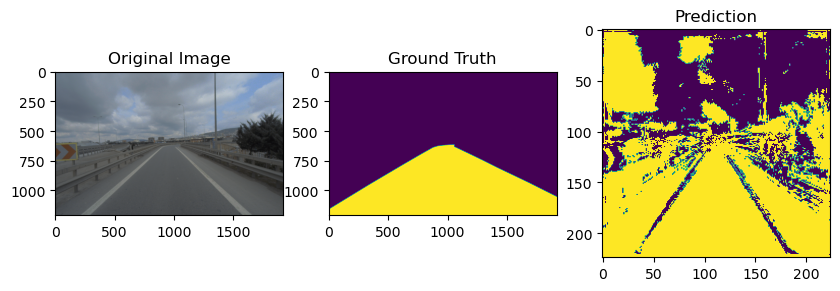

In [51]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(10,10))
axs[0].imshow(plt.imread(test_input_path_list[0]))
axs[0].set_title('Original Image')
axs[1].imshow(plt.imread(test_label_path_list[0]))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_test)
axs[2].set_title('Prediction')

## Evaluation

### IOU Score With Jaccard Index

In [52]:
target=preprocess.tensorize_mask(test_label_path_list,INPUT_SHAPE,2)
pred_test=test_outputs[0]
pred_test=torch.sigmoid(pred_test)
jaccard_index=JaccardIndex(task='binary',num_classes=2)
jaccard_index(pred_test,target[0])
    
    

tensor(0.4831)